In [ ]:
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [2]:
!pip install numpy
!pip install pandas
!pip install --upgrade pyod
! pip install combo
! conda install -c conda-forge gdal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 4.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.6-py3-none-any.whl size=175098 sha256=801e4607cdce129ed45bb1a230a11bb71e4a068c30dd1b931924f1fffc45aefe
  Stored in directory: /root/.cache/pip/wheels/5f/24/ba/b986cd4be81d12d0d11130aed62674291bf2da1b891de49aa1
Successfully built pyod
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42883 sha256=a9a4a252d5c7fdce8cf21d907043a4d9574bc02ca6683cf4f1cc2e05f234e60b
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully b

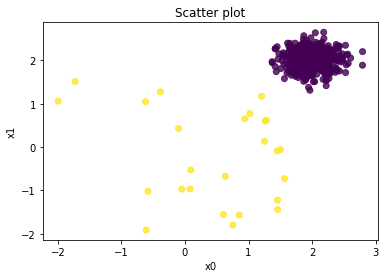

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [4]:
from pyod.models.iforest import IForest
isft = IForest(contamination=0.05, max_samples=40, behaviour='new') 
isft.fit(X_train)

# Training data
y_train_scores = isft.decision_function(X_train)
y_train_pred = isft.predict(X_train)

# Test data
y_test_scores = isft.decision_function(X_test)
y_test_pred = isft.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , isft.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: -5.24840587656783e-15
The training data: {0: 475, 1: 25}
The testing data: {0: 474, 1: 26}


In [14]:
isft.get_params()

{'behaviour': 'old',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 500,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

**To understand the relative importance of features in determining outliers. The feature importance is measured by the Gini impurity index. The values sum to 1.0.**

In [5]:
isft_vi = isft.feature_importances_
isft_vi

array([0.16668332, 0.1660883 , 0.1764841 , 0.18855255, 0.1622138 ,
       0.13997794])

**The graph shows the relative strength of features in determining outliers.**

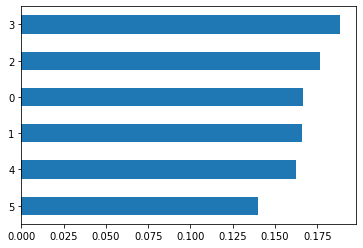

In [6]:
from matplotlib import pyplot as plt
for_plot = pd.DataFrame({'x_axis':X_train_pd.columns,
              'y_axis':isft_vi}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

**Determine a Reasonable Threshold for the Model**
The threshold is to be determined by the histogram of the outlier scores.

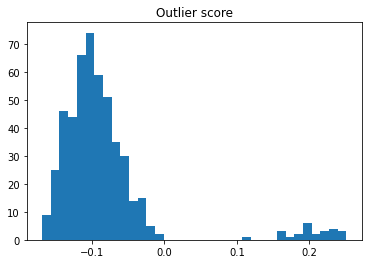

In [7]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

**A descriptive_stat_threshold() funtion is to show the sizes and descriptive statistics of the features for the normal and the outlier groups**

**The size of the outlier group**: Remember the size of the outlier group is determined by the threshold.




In [8]:
threshold = isft.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.1
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,0.2


**Now, we can produce a confusion matrix to understand the model performance. The model delivers a decent job and identifies all 25 outliers.**

In [9]:
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


**Achieve Model Stability by Aggregating Multiple Models**

Since **IForest** is a proximity-based algorithm, it is sensitive to outliers and can commit overfitting. To produce a stable prediction outcome, we can aggregate the scores produced by multiple models. 

In [10]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of the number of trees
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    #isft = IForest(contamination=0.05, max_samples=k) 
    isft = IForest(contamination=0.05, n_estimators=k) 
    isft.fit(X_train_norm)
    
    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(X_train_norm) 
    test_scores[:, i] = isft.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

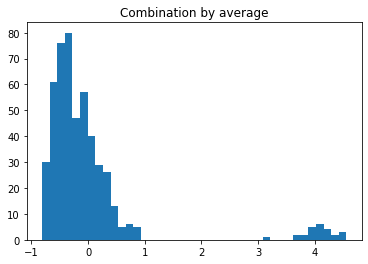

In [11]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [12]:
descriptive_stat_threshold(X_train,y_train_by_average, 1.0)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.21
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,4.07


In [13]:
descriptive_stat_threshold(X_test,y_test_by_average, 1.0)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,472,94.4,2.01,2.01,2.01,1.99,2.01,2.00,-0.20
1,Outlier,28,5.6,0.24,-0.26,0.02,0.17,0.17,0.33,3.82
